In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

shape of gray image: (600, 600)
max value: 255, min value: 0


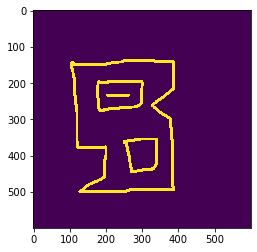

In [8]:
image = cv2.imread('./test/example.png', cv2.IMREAD_GRAYSCALE)
print(f'shape of gray image: {image.shape}')
print(f'max value: {image.max()}, min value: {image.min()}')
plt.imshow(image)

## Convert Image to Binary Image

In [9]:
image = cv2.imread('./test/example.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

## Connected Components in Binary Image

In [10]:
# find all connected components
num_labels, labels = cv2.connectedComponents(binary_image)

masks = []
for i in range(1, num_labels):
    mask = (labels == i).astype(np.uint8) * 255
    masks.append(mask)
    cv2.imshow(f'image_{i}', mask)
    cv2.waitKey()
    cv2.destroyAllWindows()

## Contours of Binary Image

In [11]:
# find convex hull of each mask in labels
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('Number of contours: ', len(contours))
for contour in contours:
    dummy_image = image.copy()
    cv2.drawContours(dummy_image, [contour], -1, (0, 255, 0), 3)
    cv2.imshow('testing contour all image', dummy_image)
    cv2.waitKey()
    cv2.destroyAllWindows()

Number of contours:  1


## Convex Hulls

In [12]:
testing_mask = masks[0]
contours, _ = cv2.findContours(testing_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hull = cv2.convexHull(contours[0])
polygon = np.squeeze(np.array(hull), axis=1)

In [13]:
testing_hull = np.stack([testing_mask] * 3, axis=2)
for i, point in enumerate(polygon):
    cv2.circle(testing_hull, center=tuple(point), radius=3, color=(0, 0, 255), thickness=-1)
    cv2.line(testing_hull, pt1=tuple(polygon[i % len(polygon)]), pt2=tuple(polygon[(i + 1) % len(polygon)]), color=(0, 255, 0), thickness=1)
cv2.imshow('convex hull', testing_hull)
cv2.waitKey()
cv2.destroyAllWindows()

In [14]:
testing_contour = np.stack([testing_mask] * 3, axis=2)
cv2.drawContours(testing_contour, [contour], -1, (0, 255, 0), 3)
cv2.imshow('draw contour', testing_contour)
cv2.waitKey()
cv2.destroyAllWindows()

## Approx Contours

In [15]:
testing_mask = masks[0]
contours, _ = cv2.findContours(testing_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]

In [16]:
# contour Perimeter
perimeter = cv2.arcLength(contour, True)
# contour approximation
epsilon = 0.01 * perimeter
approx = cv2.approxPolyDP(contour, epsilon, True)
# approximation testing
testing_approximation = np.stack([testing_mask] * 3, axis=2)
cv2.drawContours(testing_approximation, [approx], -1, (0, 255, 0), 3)
cv2.imshow('approx contour', testing_approximation)
cv2.waitKey()
cv2.destroyAllWindows()

## Convex Hull with Shapely.geometry

In [17]:
testing_mask = masks[0]
contours, _ = cv2.findContours(testing_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = np.squeeze(np.array(contours[0]), axis=1)

In [18]:
from shapely.geometry import MultiPoint
convex_hull = MultiPoint(contour).convex_hull

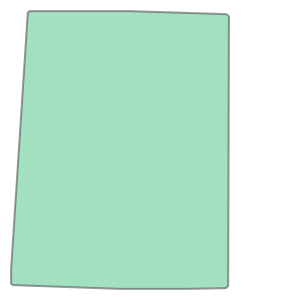

In [19]:
convex_hull

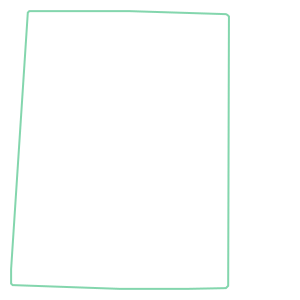

In [20]:
convex_hull.exterior

In [21]:
list(convex_hull.exterior.coords)

[(247.0, 136.0),
 (105.0, 141.0),
 (103.0, 143.0),
 (103.0, 162.0),
 (125.0, 500.0),
 (127.0, 502.0),
 (258.0, 502.0),
 (386.0, 498.0),
 (388.0, 497.0),
 (390.0, 495.0),
 (390.0, 491.0),
 (389.0, 140.0),
 (386.0, 137.0),
 (334.0, 136.0),
 (247.0, 136.0)]

## Intersection Point

In [22]:
# from shapely.geometry import LineString

# def find_intersection_point(line1, line2):
#     line1 = LineString(line1)
#     line2 = LineString(line2)
#     point = None
#     if line1.intersects(line2):
#         point = line1.intersection(line2)
#         point = point.x, point.y
#     return point

In [23]:
def intersection_point(line1, line2):
    def get_slope(point1, point2):
        if point1[0] == point2[0]:
            return None
        return (point1[1] - point2[1]) / (point1[0] - point2[0])

    def get_intercept(slope, point):
        return point[1] - slope * point[0]

    slope1 = get_slope(line1[0], line1[1])
    slope2 = get_slope(line2[0], line2[1])

    if slope1 == slope2:
        return None

    b1 = get_intercept(slope1, line1[0])
    b2 = get_intercept(slope2, line2[0])
    inter_x = int((b1 - b2) / (slope2 - slope1))
    inter_y = int(slope1 * inter_x + b1)

    return [inter_x, inter_y]

In [24]:
print(intersection_point(line1=[[0, 0], [0.5, 0.5]], line2=[[2, 0], [0, 2]]))

[1, 1]


## Function find convex hull of binary image

In [25]:
def find_convex_hulls(pred, binary_threshold=0.6, area_threshold=0.0, vertical_threshold=20):
    convex_hulls = []
    binary_image = (pred > binary_threshold).astype(np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, np.ones(shape=(5, 5), dtype=np.uint8))
    num_label, label = cv2.connectedComponents(binary_image)
    for i in range(1, num_label):
        contours, _ = cv2.findContours((label == i).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = contours[0]
        if cv2.contourArea(contour) > area_threshold * pred.size:
            epsilon = 0.009 * cv2.arcLength(contour, closed=True)
            approx_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
            convex_hull = cv2.convexHull(approx_contour) # approximate contour to reduce num of points
            for inc in range(5):
                if convex_hull.shape[0] <= vertical_threshold:
                    break
                epsilon = 0.002 * (1 + inc) * cv2.arcLength(contour, closed=True)
                convex_hull = cv2.approxPolyDP(convex_hull, epsilon, closed=True)

            if 4 <= convex_hull.shape[0] <= vertical_threshold:
                convex_hulls.append(np.squeeze(np.array(convex_hull), axis=1))

    return convex_hulls

In [26]:
def show_convex_hull(pred, polygon):
    testing_hull = np.stack([pred] * 3, axis=2)
    for i, point in enumerate(polygon):
        cv2.circle(testing_hull, center=tuple(point), radius=3, color=(0, 0, 255), thickness=-1)
        cv2.line(testing_hull, pt1=tuple(polygon[i % len(polygon)]), pt2=tuple(polygon[(i + 1) % len(polygon)]), color=(0, 255, 0), thickness=1)
    cv2.imshow('find convex hull', testing_hull)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [27]:
pred = cv2.imread('./test/example.png', cv2.IMREAD_GRAYSCALE) / 255
convex_hulls = find_convex_hulls(pred)
for polygon in convex_hulls:
    show_convex_hull(pred, polygon)

## IOU of 2 polygons

In [28]:
from shapely.geometry import Polygon

def compute_iou(polyA, polyB):
    iou = 0.
    polyA = Polygon(polyA)
    polyB = Polygon(polyB)
    if polyA.intersects(polyB):
        iou = polyA.intersection(polyB).area / polyA.union(polyB).area
    return iou

In [29]:
polyA = [[0, 0], [0, 2], [2, 2], [2, 0]]
polyB = [[1, 1], [1, 3], [3, 3], [3, 1]]
compute_iou(polyA, polyB)

0.14285714285714285

## Perspective Transform

In [30]:
def perspective_transform(image, four_points):
    four_points = np.array(four_points, dtype=np.float32)
    (tl, tr, br, bl) = four_points
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(four_points, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped 

In [31]:
image = cv2.imread('test/example.png', 0)
warp = perspective_transform(image, [(100, 100), (300, 300), (0, 0), (0, 300)])
cv2.imshow('warp', warp)
cv2.waitKey()
cv2.destroyAllWindows()

## Find Enclosing Quadrileteral

In [16]:
import cv2
import itertools
import numpy as np
from shapely.geometry import box, Point, Polygon


class EnclosingQuadrilateral:
    def __init__(self):
        self.binary_threshold = 0.6
        self.area_threshold = 0.0
        self.vertical_threshold = 20
        self.iou_threshold = 0.8

    def _order_points(self, points):
        assert len(points) == 4, 'Length of points must be 4'
        left = sorted(points, key=lambda p: p[0])[:2]
        right = sorted(points, key=lambda p: p[0])[2:]
        tl, bl = sorted(left, key=lambda p: p[1])
        tr, br = sorted(right, key=lambda p: p[1])
        return [tl, tr, br, bl]

    def _compute_iou(self, polyA, polyB):
        iou = 0.
        polyA = Polygon(polyA)
        polyB = Polygon(polyB)
        if polyA.intersects(polyB):
            iou = polyA.intersection(polyB).area / polyA.union(polyB).area
        return iou

    def _intersection_point(self, line1, line2):
        a1 = line1[1][1] - line1[0][1]
        b1 = line1[0][0] - line1[1][0]
        a2 = line2[1][1] - line2[0][1]
        b2 = line2[0][0] - line2[1][0]
        determinant = a1 * b2 - a2 * b1
        if determinant == 0:
            return None
        c1 = (a1 / determinant) * line1[0][0] + (b1 / determinant) * line1[0][1]
        c2 = (a2 / determinant) * line2[0][0] + (b2 / determinant) * line2[0][1]
        x = b2 * c1 - b1 * c2
        y = a1 * c2 - a2 * c1
        return [int(x), int(y)]

    def _convex_hulls(self, pred, binary_threshold=0.6, area_threshold=0.0, vertical_threshold=20):
        convex_hulls = []
        binary_image = (pred > binary_threshold).astype(np.uint8)
        binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, np.ones(shape=(5, 5), dtype=np.uint8))
        num_label, label = cv2.connectedComponents(binary_image)
        for i in range(1, num_label):
            contours, _ = cv2.findContours((label == i).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contour = contours[0]
            if cv2.contourArea(contour) > area_threshold * pred.size:
                epsilon = 0.009 * cv2.arcLength(contour, closed=True)
                approx_contour = cv2.approxPolyDP(contour, epsilon, closed=True)
                convex_hull = cv2.convexHull(approx_contour)  # approximate contour to reduce num of points
                for inc in range(5):
                    if convex_hull.shape[0] <= vertical_threshold:
                        break
                    epsilon = 0.002 * (1 + inc) * cv2.arcLength(contour, closed=True)
                    convex_hull = cv2.approxPolyDP(convex_hull, epsilon, closed=True)

                if 4 <= convex_hull.shape[0] <= vertical_threshold:
                    convex_hulls.append(np.squeeze(np.array(convex_hull), axis=1))

        return convex_hulls

    def _enclosing_quadrilateral(self, pred, convex_hulls, iou_threshold):
        enclosing_quads = []
        x1, x2 = [-pred.shape[0], 2 * pred.shape[0]]
        y1, y2 = [-pred.shape[1], 2 * pred.shape[1]]
        boundary = box(x1, y1, x2, y2)
        for polygon in convex_hulls:
            num_verticals = len(polygon)
            max_iou = 0.
            enclosing_quad = None
            for (x, y, z, t) in itertools.combinations(range(num_verticals), 4):
                lines = [
                    [polygon[x], polygon[(x + 1) % num_verticals]],
                    [polygon[y], polygon[(y + 1) % num_verticals]],
                    [polygon[z], polygon[(z + 1) % num_verticals]],
                    [polygon[t], polygon[(t + 1) % num_verticals]]
                ]
                points = []
                for i in range(4):
                    point = self._intersection_point(lines[i], lines[(i + 1) % 4])
                    if (not point) or (point in points) or (not boundary.contains(Point(point))):
                        break
                    points.append(point)

                if len(points) == 4 and Polygon(self._order_points(points)).is_valid:
                    candidate_quad = self._order_points(points)
                    iou = self._compute_iou(candidate_quad, polygon)
                    if iou > max_iou and iou > iou_threshold:
                        enclosing_quad = candidate_quad
                        max_iou = iou

            if enclosing_quad:
                enclosing_quads.append(enclosing_quad)

        return enclosing_quads
    
    def perspective_transform(self, original_image, pred_mask, quad):
        width_ratio = original_image.shape[1] / pred_mask.shape[1]
        height_ratio = original_image.shape[0] / pred_mask.shape[0] 
        quad = np.array(quad, dtype=np.float32)
        quad[:, 0] = quad[:, 0] * width_ratio
        quad[:, 1] = quad[:, 1] * height_ratio
        tl, tr, br, bl = quad
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype = "float32")
        M = cv2.getPerspectiveTransform(quad, dst)
        warped_image = cv2.warpPerspective(original_image, M, (maxWidth, maxHeight))
        return warped_image

    def __call__(self, original_image, pred_mask):
        warped_images = []
        convex_hulls = self._convex_hulls(pred_mask,
                                          self.binary_threshold,
                                          self.area_threshold,
                                          self.vertical_threshold)
        enclosing_quads = self._enclosing_quadrilateral(pred_mask,
                                                        convex_hulls,
                                                        self.iou_threshold)
        for quad in enclosing_quads:
            warped_images.append(self.perspective_transform(original_image, pred_mask, quad))

        return warped_images


In [3]:
import time
minEnclosingQuad = EnclosingQuadrilateral()
orginal_image = cv2.imread('./test/mask.png')
pred_mask = cv2.cvtColor(orginal_image, cv2.COLOR_BGR2GRAY) / 255.0
t1 = time.time()
warped_images = minEnclosingQuad(orginal_image, pred_mask)
t2 = time.time()
print(f'processing time: {t2 - t1}')

processing time: 0.005478620529174805


In [5]:
for warp_image in warped_images:
    cv2.imshow('warped image', warp_image)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [4]:
for quad in enclosing_quads:
    quad = np.int32(quad)
#     testing_quad = np.stack([pred] * 3, axis=2)
    testing_quad = orginal_image.copy()
    cv2.polylines(testing_quad, [quad], True, (255, 0, 0), 3)
    cv2.imshow('find quad', testing_quad)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [35]:
test_image = cv2.imread('./test/mask.jpg', cv2.IMREAD_GRAYSCALE) / 255.
enclosing_quads = minEnclosingQuad(test_image)
for quad in enclosing_quads:
    quad = np.int32(quad)
    test_quad = np.stack([pred] * 3, axis=2)
    cv2.polylines(test_quad, [quad], True, (255, 0, 0), 3)
    cv2.imshow('find quad', test_quad)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [ ]:
warp = minEnclosingQuad.perspective_transform(test_image, enclosing_quads[0])
cv2.imshow('warp', warp)
cv2.waitKey()
cv2.destroyAllWindows()

## Hough Transform

In [56]:
import cv2
image = cv2.imread('./test/mask.png')

In [57]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

In [58]:
edged_image = cv2.Canny(binary_image, ret, 255)
# https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html

In [59]:
cv2.imshow('image', edged_image)
cv2.waitKey()
cv2.destroyAllWindows()

# ...

In [7]:
from maskrcnn import MaskrcnnResnet50FPN
import torch

image_size = (768, 768)
weight_path = './weight/2011110823/best_model_31_dice_mAP=0.9705.pt'

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MaskrcnnResnet50FPN(num_classes=3)
model.load_state_dict(torch.load(weight_path, map_location='cpu'))
model.to(device)
model.eval()

MaskrcnnResnet50FPN(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
  

In [10]:
def preprocessing(image):
    '''
    input: image: [H, W, C]
    output: samples: [1, C, H', W']
    '''
    sample = cv2.resize(image, dsize=image_size)
    sample = torch.from_numpy(sample).to(device).to(torch.float)
    samples = sample.unsqueeze(dim=0).permute(0, 3, 1, 2)
    samples = (samples - samples.mean(dim=(1, 2, 3))) / samples.std(dim=(1, 2, 3))
    return image, samples

def processing(image, samples):
    with torch.no_grad():
        preds = model(samples)
    return image, preds

def postprocessing(image, preds):
    pred = preds[0]
    boxes = pred['boxes']
    masks = pred['masks']
    scores = pred['scores']
    labels = pred['labels']
    
    indices = scores > 0.5
    masks = masks[indices]
    labels = labels[indices]
    
    indices = torchvision.ops.nms(boxes, scores, 0.5)
    masks = masks[indices]
    scores = scores[indices]
    labels = labels[indices]  
    
    labels = labels.detach().cpu().numpy()
    masks = masks.squeeze(1).detach().cpu().numpy()
    
    return image, labels, masks

In [11]:
import torchvision

test_image = cv2.imread('test/GiayCMND.png')
image, samples = preprocessing(test_image)
image, preds = processing(image, samples)
image, labels, masks = postprocessing(image, preds)

/home/vinhloiit/.local/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [17]:
minEnclosingQuad = EnclosingQuadrilateral()
for mask in masks:
    warped_images = minEnclosingQuad(test_image, mask)
    for warped_image in warped_images:
        cv2.imshow('result', warped_image)
        cv2.waitKey()
        cv2.destroyAllWindows()